<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
# path_root = '/content/drive/MyDrive/datas/'
path_root = '/Users/sanghunoh/Develops/repository/own/study_machinglearning/datas'

# 작업 경로 설정
import os
os.chdir(path_root)
!ls

HW3Data_1.mat
HW4_COIL20.mat
HW5Data_1.mat
HW5Data_2.mat
README.md
dataCh4_7.zip
digitimages_binary.zip
iris.zip
mpie_30_shuffle
mpie_30_shuffle.zip
results_CNN_.pickle
results_CNN_label_1.csv
results_CNN_label_1.png
results_CNN_label_1_202205301442.pickle
results_CNN_label_2.csv
results_CNN_label_2.png
results_CNN_label_2_202205301442.pickle
results_CNN_label_4.csv
results_CNN_label_4.png
results_CNN_label_4_202205301442.pickle
results_CNN_label_all.csv
results_CNN_label_all.png
results_Finetuning_label_1_202205301519.pickle
results_Finetuning_label_2_202205301519.pickle
results_Finetuning_label_4_202205301519.pickle
results_MLP_.pickle
results_MLP_label_0_202205301020.pickle
results_MLP_label_3_202205301020.pickle
results_MLP_label_5_202205301020.pickle


In [2]:
# config param
file_prefix = 'results_MLP_label_'  # file name
save_file = True  # save graph, csv 
global rank 
rank = 10

In [3]:
import glob

filename_list = []
for file_name in glob.glob(f"./{file_prefix}*.pickle"):
    filename_list.append(file_name)
filename_list

['./results_MLP_label_5_202205301020.pickle',
 './results_MLP_label_3_202205301020.pickle',
 './results_MLP_label_0_202205301020.pickle']

##Load Trained Model

In [4]:
import pickle
results_list = list()
for filename in filename_list:
  with open(filename, 'rb') as f:
    results_list.append(pickle.load(f))
len(results_list)   # model, history, execution_time, _params

2022-06-01 01:44:24.238874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 01:44:24.238967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



3

##create DataFrame with concate params from results

###결과값을 순서 맞게 나열하기
순서 : params + history values + model layers + training time + history params


In [5]:
import numpy as np
def resultToValueslist(model, history, training_time, params):
  model_layer_depth = [len(model.layers)]
  history_values = list(np.array(list(history.history.values()))[:,-1])
  history_params = list(history.params.values())
  _training_time = [training_time]
  params_values = list(params.values())
  _value_list = params_values + history_values + model_layer_depth + _training_time + history_params
  return _value_list
# value_list

###학습결과값을 DataFrame으로 만들기

In [6]:
# merge column epochs (epochs 컬럼 2개임)
import pandas as pd

def mergeColumnWithepochs(dataframe):
  # dataframe = _dataframe.copy()
  _epochs_temp = dataframe['epochs']
  _epochs_temp = _epochs_temp.iloc[:,0]
  dataframe.drop(labels=['epochs', 'verbose'], axis=1, inplace=True)
  _result_df = pd.concat([dataframe, _epochs_temp],axis=1)
  return _result_df

In [7]:
def valueslistToDataFrame(_result_per_label_list):
  _results_list = list()
  for _results in _result_per_label_list:
    _model, _history, _training_time, _params = _results[0], _results[1], _results[2], _results[3]
    # print(f'Training Time : {_training_time:.3f} sec')
    _results_list.append(resultToValueslist(_model, _history, _training_time, _params))
  _column_name = list(_params.keys())+list(_history.history.keys())+['model_layer_depth','training_time']+list(_history.params.keys())

  # print(f'valueslistToDataFrame : {len(_results_list)}, column_name: {_column_name}')
  _result_df = pd.DataFrame(_results_list, columns=_column_name)
  _result_df = mergeColumnWithepochs(_result_df)

  # loss - val_loss and accuracy - val_accuracy
  _result_df['loss_gap'] = _result_df['loss'] - _result_df['val_loss']
  _result_df['accuracy_gap'] = _result_df['accuracy'] - _result_df['val_accuracy']

  # check rank count
  rows_count = _result_df.shape[0]
  global rank
  if rank >= rows_count:
    rank = rows_count
    print(f'rank : {rank}')
  return _result_df

###label_class 별로 DataFrame을 list 담기

In [8]:
import pandas as pd

results_df_list = list()
for result_per_label_list in results_list:
  results_df_list.append(valueslistToDataFrame(result_per_label_list))

In [9]:
# results_df_list[0]

##Evaluation

###Per Label class

In [10]:
evaluation_columns = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'loss_gap', 'accuracy_gap']

In [11]:
def sortEvaluationColumns(_results_df):
  _evaluation_df = _results_df.sort_values(evaluation_columns, ascending = [True, False, True, False, True, True])
  print(len(_evaluation_df.columns), _evaluation_df.columns)
  return _evaluation_df

In [12]:
evaluation_df_list = list()
for results_df in results_df_list:
  evaluation_df_list.append(sortEvaluationColumns(results_df))
# evaluation_df


18 Index(['_hidden_layers', 'dense_count', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', 'label_class', '_class_cnt', 'loss',
       'accuracy', 'val_loss', 'val_accuracy', 'model_layer_depth',
       'training_time', 'steps', 'epochs', 'loss_gap', 'accuracy_gap'],
      dtype='object')
18 Index(['_hidden_layers', 'dense_count', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', 'label_class', '_class_cnt', 'loss',
       'accuracy', 'val_loss', 'val_accuracy', 'model_layer_depth',
       'training_time', 'steps', 'epochs', 'loss_gap', 'accuracy_gap'],
      dtype='object')
18 Index(['_hidden_layers', 'dense_count', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', 'label_class', '_class_cnt', 'loss',
       'accuracy', 'val_loss', 'val_accuracy', 'model_layer_depth',
       'training_time', 'steps', 'epochs', 'loss_gap', 'accuracy_gap'],
      dtype='object')


In [13]:
evaluation_df_list_rank = list()
for evaluation_df in evaluation_df_list:
  evaluation_df_list_rank.append(evaluation_df[:rank])

In [14]:
evaluation_df_list_rank[2]

,_hidden_layers,dense_count,_kernel_initializer,_activation,_optimizer,batch_normal,label_class,_class_cnt,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
23,3,16,glorot_uniform,sigmoid,Adam,True,0,30,0.201076,0.938477,0.239688,0.925482,9,103.347586,1024,10,-0.038611,0.012995
19,3,16,glorot_uniform,sigmoid,SGD,True,0,30,0.217881,0.936836,0.797048,0.774872,9,93.962287,1024,10,-0.579167,0.161963
22,3,16,glorot_uniform,sigmoid,Adam,True,0,30,0.316600,0.903456,0.912464,0.739678,9,51.882599,1024,5,-0.595864,0.163778
29,3,16,glorot_uniform,relu,Adam,False,0,30,0.408044,0.859053,0.540501,0.829335,5,53.377203,1024,10,-0.132457,0.029717
7,3,8,glorot_uniform,sigmoid,Adam,True,0,30,0.410590,0.863587,0.459326,0.845458,9,106.703803,1024,10,-0.048736,0.018129
18,3,16,glorot_uniform,sigmoid,SGD,True,0,30,0.411813,0.885214,2.572803,0.406017,9,48.152951,1024,5,-2.160990,0.479198
31,3,16,glorot_uniform,relu,Adam,True,0,30,0.507811,0.836460,0.333653,0.894416,9,103.047013,1024,10,0.174158,-0.057956
3,3,8,glorot_uniform,sigmoid,SGD,True,0,30,0.577865,0.822467,4.752256,0.270350,9,96.077396,1024,10,-4.174391,0.552117
30,3,16,glorot_uniform,relu,Adam,True,0,30,0.591183,0.811814,0.426339,0.863154,9,52.860950,1024,5,0.164843,-0.051340
6,3,8,glorot_uniform,sigmoid,Adam,True,0,30,0.594075,0.813365,0.412392,0.881243,9,53.257383,1024,5,0.181683,-0.067878


###draw evaluation

In [15]:
import matplotlib.pyplot as plt

def drawEvaluation(_evaluation_df, _save_file=False, _label=None):
  plt.rcParams["figure.figsize"] = (15, 5)

  plt.subplot(121)
  _evaluation_df[['loss', 'val_loss']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  plt.title('loss rate')
  # plt.xticks(rotation=20)

  plt.subplot(122)
  _evaluation_df[['accuracy', 'val_accuracy']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  # plt.xticks(rotation=20)
  plt.title('accuracy rate')

  _label_class = _label
  if not _label:
    row_name = evaluation_df_rank.index[0]
    _label_class = _evaluation_df.loc[row_name,'label_class']
  
  plt.suptitle(f'label_class : {_label_class}')
  if _save_file:
    _file_name = file_prefix + str(_label_class) + '.png'
    plt.savefig(_file_name)
  plt.show()


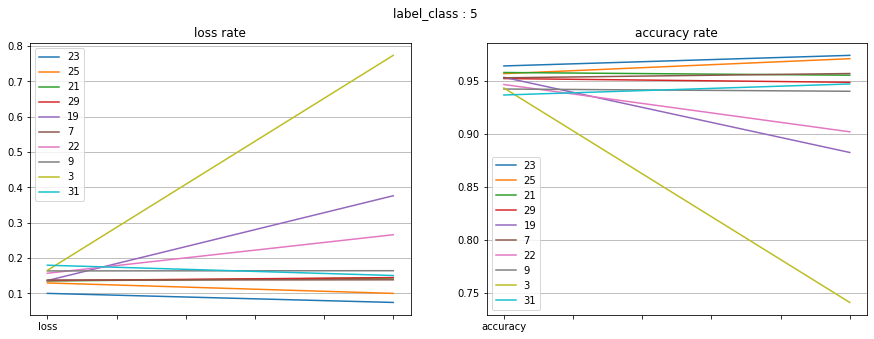

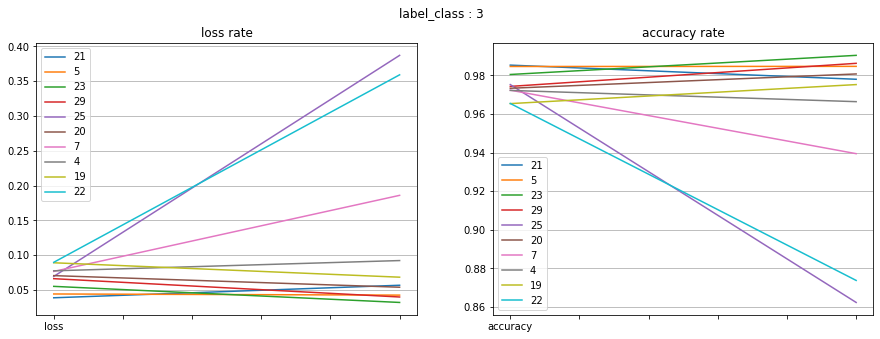

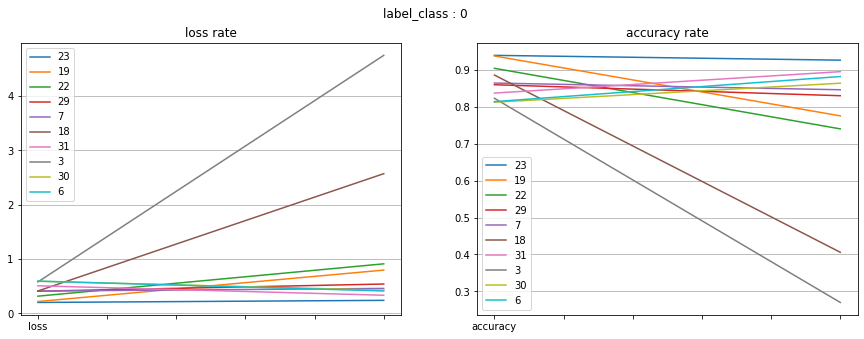

In [16]:
for evaluation_df_rank in evaluation_df_list_rank:
  drawEvaluation(evaluation_df_rank, save_file)


###성능 영향 준 Parameters

In [17]:
def getParametersByPerformance(evaluation_df, _save_file=False, _label=None):
  _evaluation_df = evaluation_df.copy()
  _label_class = _label
  if not _label:
    row_name = evaluation_df_rank.index[0]
    _label_class = _evaluation_df.loc[row_name,'label_class']

  # 성능 영향 없는 컬럼 빼기
  exclusive_columns = evaluation_columns + ['training_time']
  columns_mask_str = _evaluation_df.columns.map(lambda x: True if (x not in exclusive_columns) else False )
  # print(columns_mask_str, len(list(columns_mask_str)))

  # 성능 영향 준 요인이 하나 이상인 컬럼 찾기
  performance_df = _evaluation_df.loc[:,columns_mask_str].value_counts().reset_index()
  performance_df.drop(labels=0, axis=1, inplace=True)
  _measure_columns = list()
  for column in performance_df.columns:
    if len(performance_df[column].unique()) > 1:
      _measure_columns.append(column)
  # print(_measure_columns)

  # 빼었던 컬럼 + 영향 요인 컬럼 합하기
  result_columns = exclusive_columns + _measure_columns
  _evaluation_df = _evaluation_df[result_columns]

  if _save_file:  # 저장 여부
    _file_name = file_prefix + str(_label_class) + '.csv'
    _evaluation_df.to_csv(_file_name)

  return _evaluation_df

In [18]:
performance_params_df_list = list()
for evaluation_df_rank in evaluation_df_list_rank:
  performance_params_df_list.append(getParametersByPerformance(evaluation_df_rank, save_file))
# performance_params_df_list[-1]

In [19]:
performance_params_df_list[0]

,loss,val_loss,accuracy,val_accuracy,loss_gap,accuracy_gap,training_time,dense_count,_activation,_optimizer,batch_normal,model_layer_depth,epochs
23,0.100289,0.074645,0.963884,0.973850,0.025644,-0.009966,107.759951,16,sigmoid,Adam,True,9,10
25,0.129865,0.100285,0.956614,0.970704,0.029580,-0.014090,49.871351,16,relu,SGD,False,5,10
21,0.135538,0.143858,0.957708,0.955171,-0.008320,0.002537,55.736177,16,sigmoid,Adam,False,5,10
29,0.136579,0.144991,0.952001,0.948486,-0.008412,0.003515,55.817709,16,relu,Adam,False,5,10
19,0.136586,0.376583,0.953174,0.882422,-0.239997,0.070752,99.989912,16,sigmoid,SGD,True,9,10
7,0.138037,0.138715,0.952705,0.956744,-0.000678,-0.004039,109.614472,8,sigmoid,Adam,True,9,10
22,0.157193,0.266210,0.946392,0.901888,-0.109017,0.044505,54.662668,16,sigmoid,Adam,True,9,5
9,0.163866,0.164477,0.942151,0.940031,-0.000611,0.002120,52.650391,8,relu,SGD,False,5,10
3,0.165456,0.773859,0.943089,0.741251,-0.608403,0.201839,99.911733,8,sigmoid,SGD,True,9,10
31,0.179992,0.150858,0.936523,0.946913,0.029134,-0.010390,107.895538,16,relu,Adam,True,9,10


##Concate All Dataset for Performance

In [20]:
results_df_all = pd.concat(results_df_list).reset_index()
results_df_all.drop(labels='index', axis=1, inplace=True)
results_df_all

,_hidden_layers,dense_count,_kernel_initializer,_activation,_optimizer,batch_normal,label_class,_class_cnt,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
0,3,8,glorot_uniform,sigmoid,SGD,False,5,4,1.307984,0.311410,1.309685,0.309870,5,24.667577,1024,5,-0.001701,0.001540
1,3,8,glorot_uniform,sigmoid,SGD,False,5,4,1.305595,0.299797,1.310240,0.308101,5,49.277710,1024,10,-0.004645,-0.008304
2,3,8,glorot_uniform,sigmoid,SGD,True,5,4,0.230131,0.921263,0.348462,0.867676,9,50.836309,1024,5,-0.118331,0.053587
3,3,8,glorot_uniform,sigmoid,SGD,True,5,4,0.165456,0.943089,0.773859,0.741251,9,99.911733,1024,10,-0.608403,0.201839
4,3,8,glorot_uniform,sigmoid,Adam,False,5,4,0.563798,0.780108,0.516820,0.800236,5,28.048331,1024,5,0.046978,-0.020128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,3,16,glorot_uniform,relu,SGD,True,0,30,0.713237,0.766182,2.247256,0.438655,9,94.433672,1024,10,-1.534020,0.327527
92,3,16,glorot_uniform,relu,Adam,False,0,30,1.370452,0.511075,1.375305,0.514943,5,26.900381,1024,5,-0.004853,-0.003868
93,3,16,glorot_uniform,relu,Adam,False,0,30,0.408044,0.859053,0.540501,0.829335,5,53.377203,1024,10,-0.132457,0.029717
94,3,16,glorot_uniform,relu,Adam,True,0,30,0.591183,0.811814,0.426339,0.863154,9,52.860950,1024,5,0.164843,-0.051340


In [21]:
evaluation_df_all = sortEvaluationColumns(results_df_all)
evaluation_df_all

18 Index(['_hidden_layers', 'dense_count', '_kernel_initializer', '_activation',
       '_optimizer', 'batch_normal', 'label_class', '_class_cnt', 'loss',
       'accuracy', 'val_loss', 'val_accuracy', 'model_layer_depth',
       'training_time', 'steps', 'epochs', 'loss_gap', 'accuracy_gap'],
      dtype='object')


,_hidden_layers,dense_count,_kernel_initializer,_activation,_optimizer,batch_normal,label_class,_class_cnt,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
53,3,16,glorot_uniform,sigmoid,Adam,False,3,2,0.038761,0.985303,0.056761,0.977979,5,53.560703,1024,10,-0.018000,0.007325
37,3,8,glorot_uniform,sigmoid,Adam,False,3,2,0.044226,0.984600,0.042586,0.984664,5,54.640375,1024,10,0.001640,-0.000064
55,3,16,glorot_uniform,sigmoid,Adam,True,3,2,0.055162,0.980457,0.032058,0.990366,9,102.929318,1024,10,0.023104,-0.009909
61,3,16,glorot_uniform,relu,Adam,False,3,2,0.066204,0.974281,0.039882,0.986237,5,57.520725,1024,10,0.026322,-0.011956
57,3,16,glorot_uniform,relu,SGD,False,3,2,0.069438,0.975219,0.387033,0.862367,5,48.089008,1024,10,-0.317595,0.112852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,3,8,glorot_uniform,sigmoid,Adam,False,0,30,2.745566,0.117888,2.716187,0.129965,5,28.067294,1024,5,0.029379,-0.012077
80,3,16,glorot_uniform,sigmoid,SGD,False,0,30,3.381122,0.039772,3.384531,0.040897,5,23.752438,1024,5,-0.003409,-0.001125
64,3,8,glorot_uniform,sigmoid,SGD,False,0,30,3.381995,0.038965,3.384221,0.040503,5,24.922615,1024,5,-0.002226,-0.001538
65,3,8,glorot_uniform,sigmoid,SGD,False,0,30,3.382027,0.040494,3.384175,0.040700,5,48.504896,1024,10,-0.002148,-0.000206


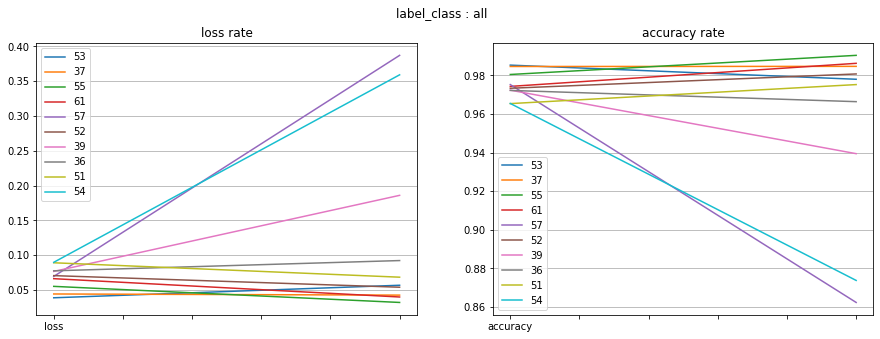

In [22]:
evaluation_df_all_rank = evaluation_df_all[:rank]
drawEvaluation(evaluation_df_all_rank, save_file, _label='all')

In [23]:
getParametersByPerformance(evaluation_df_all_rank, save_file, _label='all')

,loss,val_loss,accuracy,val_accuracy,loss_gap,accuracy_gap,training_time,dense_count,_activation,_optimizer,batch_normal,model_layer_depth,epochs
53,0.038761,0.056761,0.985303,0.977979,-0.018000,0.007325,53.560703,16,sigmoid,Adam,False,5,10
37,0.044226,0.042586,0.984600,0.984664,0.001640,-0.000064,54.640375,8,sigmoid,Adam,False,5,10
55,0.055162,0.032058,0.980457,0.990366,0.023104,-0.009909,102.929318,16,sigmoid,Adam,True,9,10
61,0.066204,0.039882,0.974281,0.986237,0.026322,-0.011956,57.520725,16,relu,Adam,False,5,10
57,0.069438,0.387033,0.975219,0.862367,-0.317595,0.112852,48.089008,16,relu,SGD,False,5,10
52,0.070583,0.053928,0.973320,0.980731,0.016655,-0.007411,26.820351,16,sigmoid,Adam,False,5,5
39,0.076597,0.185917,0.972327,0.939442,-0.109320,0.032885,104.731367,8,sigmoid,Adam,True,9,10
36,0.077489,0.092227,0.972203,0.966378,-0.014738,0.005825,27.280122,8,sigmoid,Adam,False,5,5
51,0.089058,0.068345,0.965369,0.975226,0.020712,-0.009857,94.254119,16,sigmoid,SGD,True,9,10
54,0.089702,0.359068,0.965440,0.873771,-0.269366,0.091669,51.643069,16,sigmoid,Adam,True,9,5
